In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

pd.plotting.register_matplotlib_converters()

Goal: Anomaly in number of web pages accessed in a day by a user. A bot copying curriculum? 

In [3]:
colnames = ['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip']
df = pd.read_csv("anonymized-curriculum-access.txt.gz", 
                 sep="\s", 
                 header=None, 
                 names = colnames, 
                 usecols=[0, 2, 3, 4, 5])
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [4]:
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

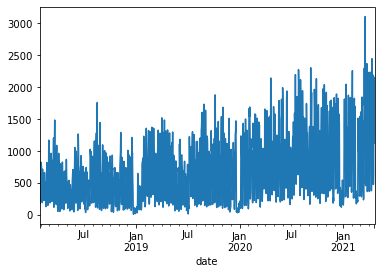

In [5]:
pages.plot()

In [6]:
end_train = '2020-06-30'
start_test = '2020-07-01'

train = pages[:end_train]
test = pages[start_test:]

In [7]:
train.tail()
test.head()

date
2020-07-01    814
2020-07-02    630
2020-07-03    280
2020-07-04    252
2020-07-05    290
Freq: D, Name: endpoint, dtype: int64

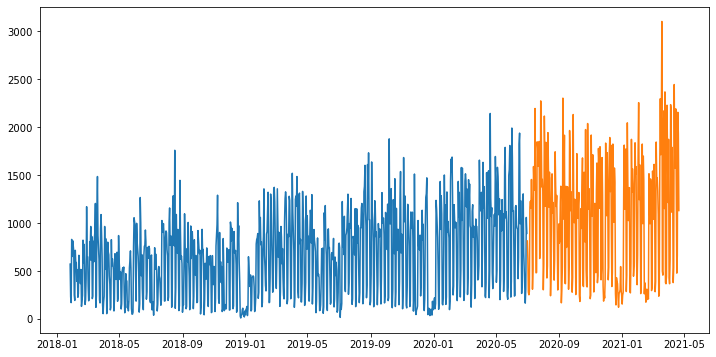

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(train)
plt.plot(test)
plt.show()

In [9]:
pages.isnull().sum()

0

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [10]:
# 7 day EMA
ema_short = train.ewm(span=7).mean()
ema_short.head()

date
2018-01-26    572.000000
2018-01-27    376.571429
2018-01-28    287.243243
2018-01-29    485.737143
2018-01-30    540.235595
Freq: D, Name: endpoint, dtype: float64

In [11]:
# 14 days EMA
ema_mid = train.ewm(span=14).mean()
ema_mid.head()

date
2018-01-26    572.000000
2018-01-27    388.785714
2018-01-28    305.208829
2018-01-29    465.757252
2018-01-30    514.347700
Freq: D, Name: endpoint, dtype: float64

In [12]:
# 30 days EMA
ema_long = train.ewm(span=30).mean()
ema_long.head()

date
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: endpoint, dtype: float64

In [15]:
# 90 days EMA
ema_90d = train.ewm(span=90).mean()
ema_90d.head()

date
2018-01-26    572.000000
2018-01-27    399.100000
2018-01-28    321.030081
2018-01-29    452.545042
2018-01-30    494.228442
Freq: D, Name: endpoint, dtype: float64

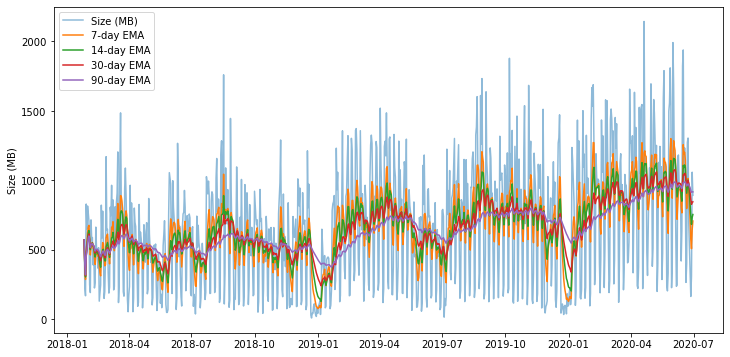

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, ema_short, label = '7-day EMA')
ax.plot(train.index, ema_mid, label = '14-day EMA')
ax.plot(train.index, ema_long, label = '30-day EMA')
ax.plot(train.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [17]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

midband.head(2)

date
2018-01-26    572.0
2018-01-27    395.3
Freq: D, Name: endpoint, dtype: float64

In [18]:
# compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head(2)

date
2018-01-26           NaN
2018-01-27    241.830519
Freq: D, Name: endpoint, dtype: float64

In [20]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns=['ub', 'lb']
bb.head(3)

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1120.791557,-330.191557
2018-01-28,956.773991,-326.494835


In [21]:
train = pd.concat([train, midband, bb], axis=1)
train.columns = ['size_gb', 'midband', 'ub', 'lb']

In [23]:

train = train.rename({'size_gb': 'pages'}, axis=1)

In [24]:
train.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557
2018-01-28,170,315.139578,956.773991,-326.494835
2018-01-29,830,457.002386,1406.405897,-492.401124
2018-01-30,652,501.369064,1354.808245,-352.070116


Plot the bands

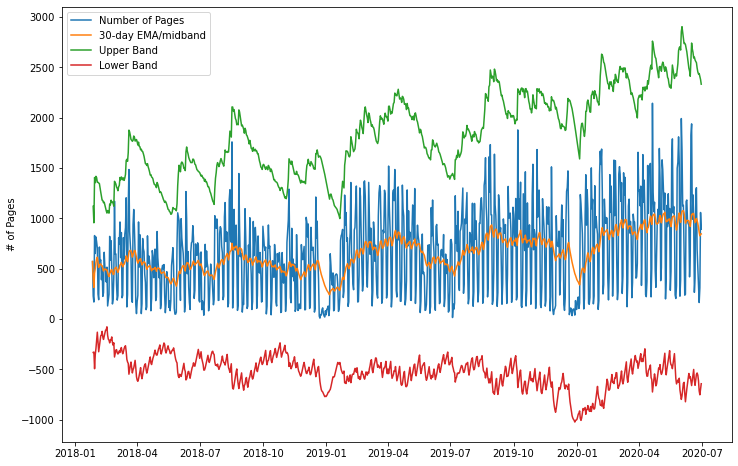

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.pages, label='Number of Pages')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('# of Pages')

plt.show()

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [27]:
# get the last measure of gb
last_measure = train.iloc[-1].pages
last_measure

893.0

In [28]:
train.tail()

,pages,midband,ub,lb
date,,,,
2020-06-26,357,911.669567,2434.413482,-611.074347
2020-06-27,165,863.497337,2439.069749,-712.075075
2020-06-28,311,827.852347,2407.028735,-751.324040
2020-06-29,1059,842.765099,2379.947762,-694.417564
2020-06-30,893,846.006061,2333.252316,-641.240195


In [29]:
# get the lower band value on the last date
last_lb = train.iloc[-1].lb
last_lb

-641.2401949137454

In [30]:
# get the upper band value on the last date
last_ub = train.iloc[-1].ub
last_ub

2333.2523160975134

In [31]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.52


So, to compute for each point in time: 

In [32]:
train['pct_b'] = (train['pages'] - train['lb'])/(train['ub'] - train['lb'])

train.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,1120.791557,-330.191557,0.386077
2018-01-28,170,315.139578,956.773991,-326.494835,0.386899
2018-01-29,830,457.002386,1406.405897,-492.401124,0.696438
2018-01-30,652,501.369064,1354.808245,-352.070116,0.588249


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [146]:
train[train['pct_b']>1]

,size_gb,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [35]:
def acquire(file_name, column_names):
    return pd.read_csv(file_name, sep="\s", header=None, names=column_names, usecols=[0,2,3,4,5])

In [37]:
df = acquire(file_name="anonymized-curriculum-access.txt.gz", 
       column_names=['date', 'endpoint', 'user_id', 'cohort_id', 'source_ip'])

In [38]:
def prep(df, user):
    df = df[df.user_id == user]
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    pages = df['endpoint'].resample('d').count()
    
    return pages

In [39]:
pages = prep(df)
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [ ]:
def wrangle(file_name, column_names):
    df = acquire(file_name, column_names)
    pages = prep(df)
    return pages

1. Compute Midband
2. Compute upper and lower band
3. Append to train
4. compute %b
5. Search for anomalies

In [43]:
def compute_pct_b(pages, span, weight):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['user_id'] = user
    
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    return my_df

In [41]:
my_df = compute_pct_b(pages, span=30, weight=2)

In [42]:
my_df[my_df.pct_b > 1]

,pages,midband,ub,lb,pct_b
date,,,,,
2018-02-27,1171,496.375166,1077.905985,-85.155652,1.080042
2018-03-20,1486,665.021495,1472.918024,-142.875035,1.008096
2018-05-30,1056,400.137163,1018.214066,-217.939741,1.030567
2018-07-23,1027,435.495343,1010.366096,-139.375411,1.014468
2018-08-17,1760,751.910516,1655.512283,-151.691251,1.057817
2018-11-08,1291,561.449002,1248.899313,-126.001309,1.030621
2019-01-28,1232,447.643274,1168.205223,-272.918675,1.044267
2019-07-08,1225,479.213223,1215.420161,-256.993715,1.006506
2019-10-07,1879,803.738383,1792.312562,-184.835797,1.043845


In [ ]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

# compute exponential stdev
stdev = train.ewm(span=span).std()

# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)
bb.columns=['ub', 'lb']

train = pd.concat([train, midband, bb], axis=1)
train.columns = ['pages', 'midband', 'ub', 'lb']


# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))